In [6]:
import pandas as pd

path = 'SAMPLE_DATA_SET.xlsx'

# Read and load dataset
df= pd.read_excel(path, sheet_name=[0, 1])

INPUT DATA

In [7]:
X =df.get(0)
X = (X.iloc[:,1:]).values
X = X.T
print(X.shape)

(839, 444)


OUTPUT DATA

In [8]:
Y =df.get(1)
Y = (Y.iloc[:,:]).values
print(Y.shape)

(839, 2)


In [14]:
a1 = 0.01
a2 = 0.001

**ELASTIC NET with coordinate descent**

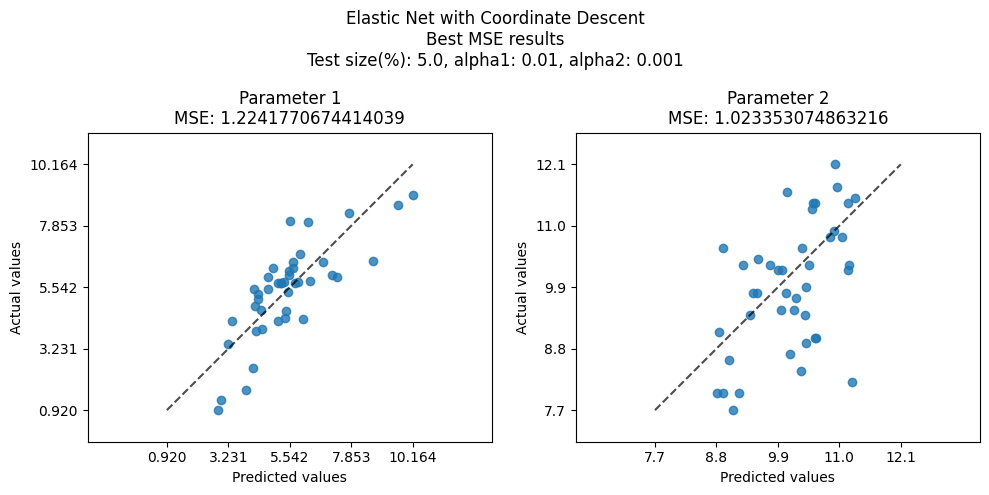

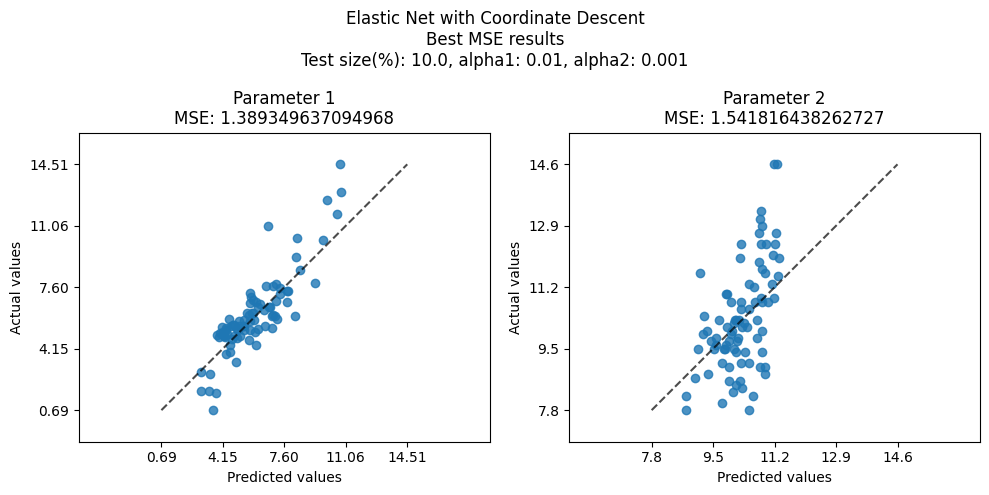

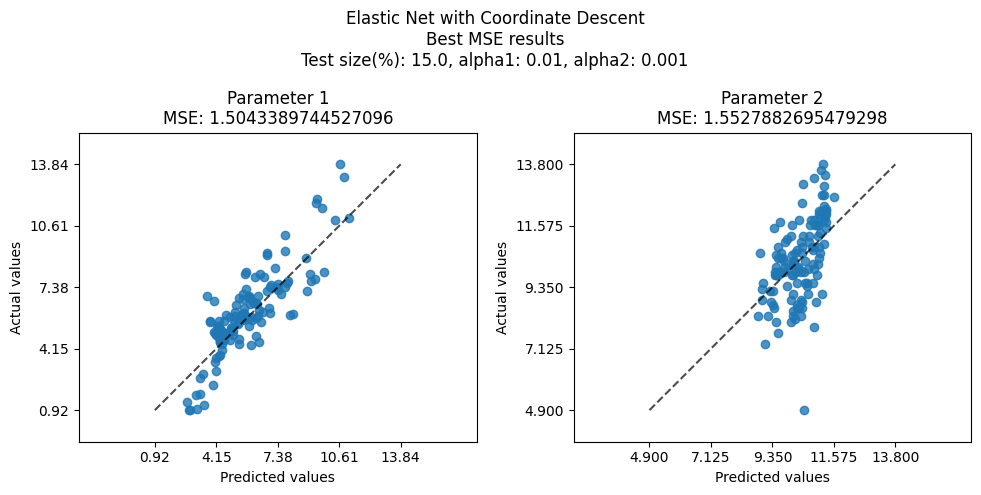

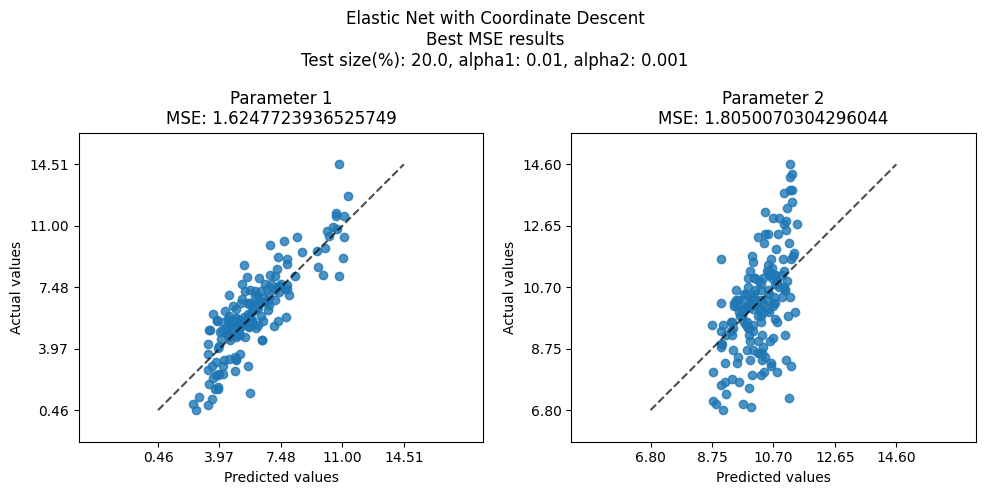

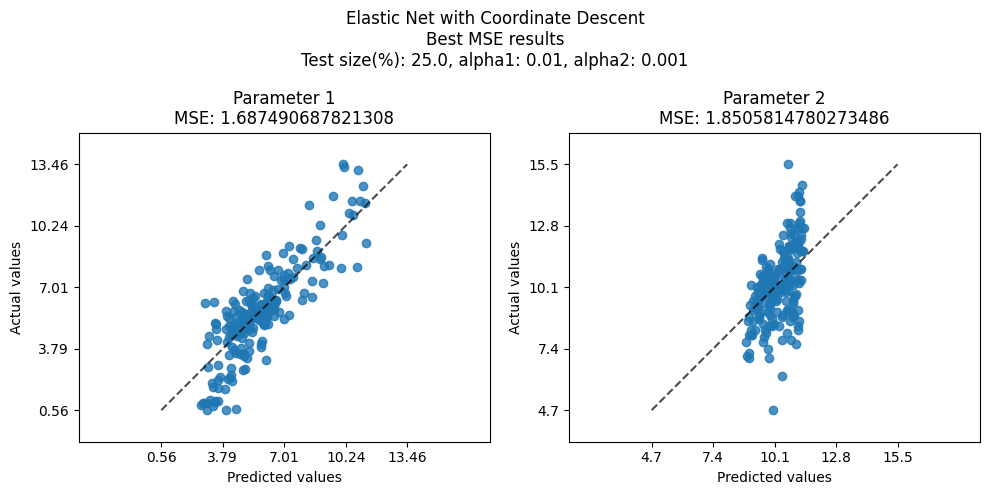

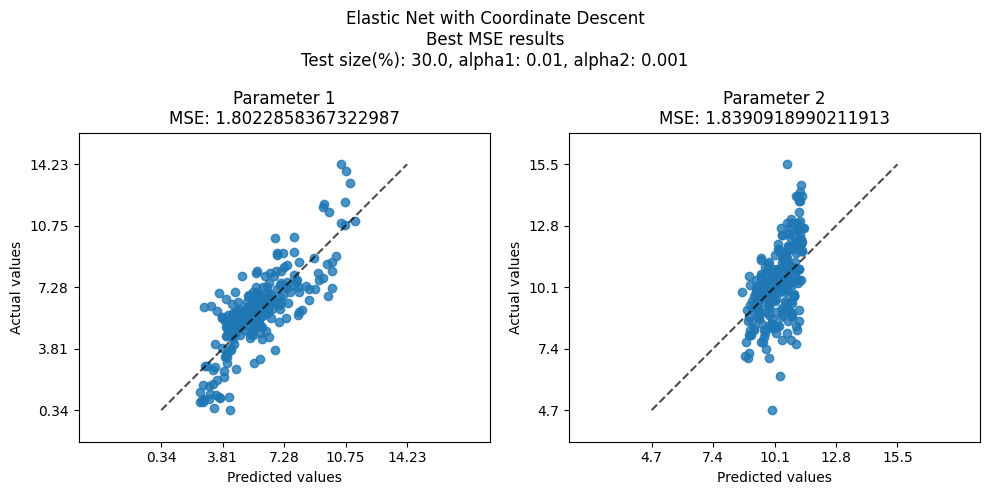

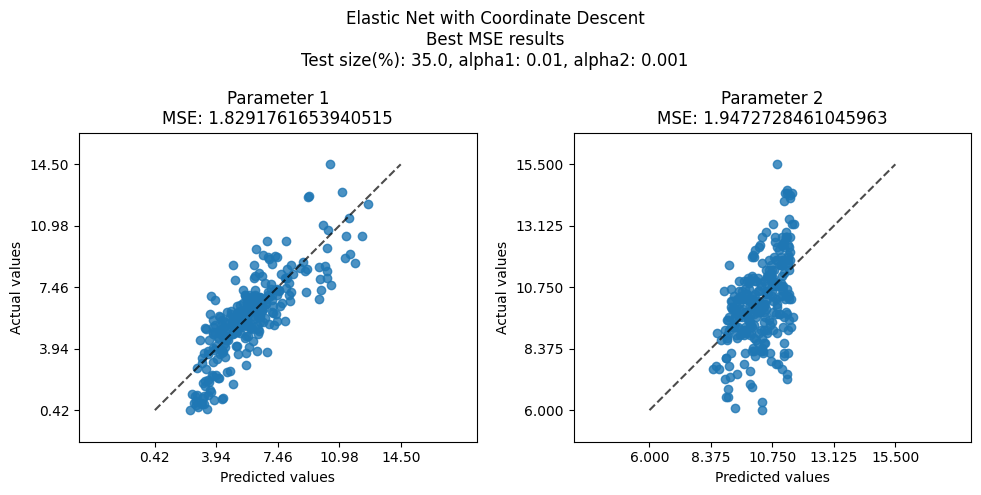

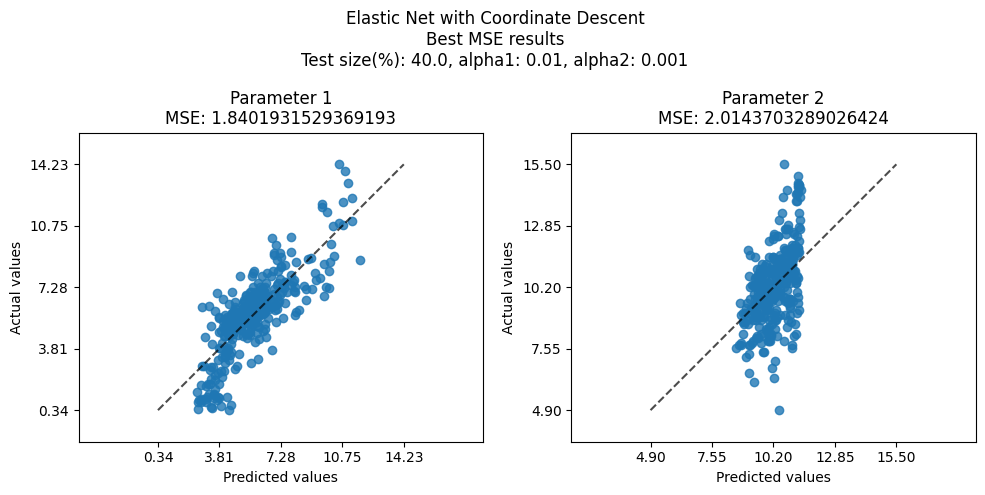

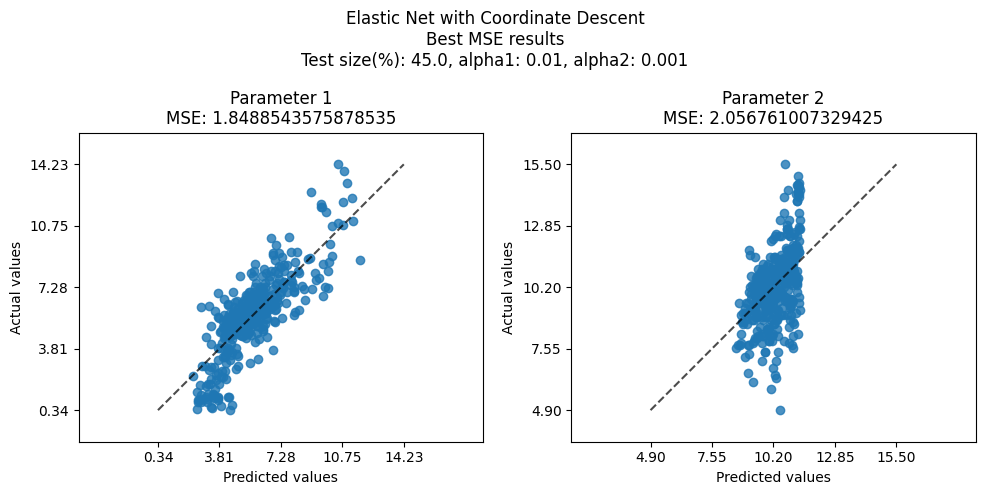

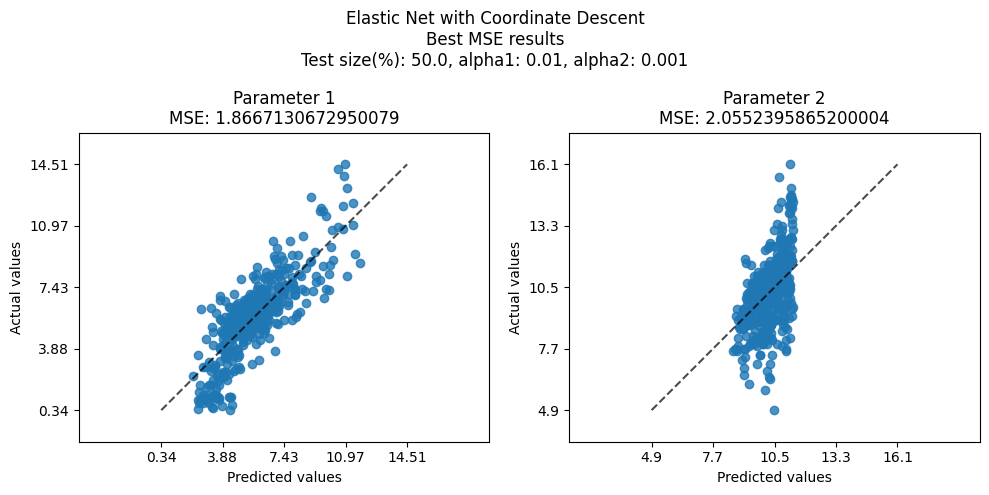

╔════════════════╦══════════════╦══════════════╦══════════════╦══════════════╦═════════════╦═════════════╗
║   Test size(%) ║   Best(MSE1) ║   Best(MSE2) ║   Mean(MSE1) ║   Mean(MSE2) ║   Var(MSE1) ║   Var(MSE2) ║
╠════════════════╬══════════════╬══════════════╬══════════════╬══════════════╬═════════════╬═════════════╣
║              5 ║      1.22418 ║      1.02335 ║      2.07855 ║      2.44799 ║   0.280171  ║   0.551165  ║
║             10 ║      1.38935 ║      1.54182 ║      2.08119 ║      2.43434 ║   0.142152  ║   0.266938  ║
║             15 ║      1.50434 ║      1.55279 ║      2.11242 ║      2.39998 ║   0.100137  ║   0.176943  ║
║             20 ║      1.62477 ║      1.80501 ║      2.13035 ║      2.40308 ║   0.0596782 ║   0.127621  ║
║             25 ║      1.68749 ║      1.85058 ║      2.16887 ║      2.41524 ║   0.047986  ║   0.0967728 ║
║             30 ║      1.80229 ║      1.83909 ║      2.18542 ║      2.41993 ║   0.0311994 ║   0.079192  ║
║             35 ║      1.82918 ║    

In [15]:
from sklearn.metrics import mean_squared_error, PredictionErrorDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from tabulate import tabulate
from sklearn.linear_model import ElasticNet

#number of trials
trials = 100
np.random.seed(42)
seeds = np.random.randint(trials, size=trials)

ripartisions = [i/100 for i in range(5,55,5)]
results = []  #["Ripartition", "Best_MSE1", "Best_MSE2","MSE1_mean","MSE2_mean","MSE1_var","MSE2_var"]


for ripartition in ripartisions:

    '''PARAM 1'''

    MSE_param1 = []

    best_MSE_1 = 100000000
    best_data_1 = {"Y_test":None, "Y_pred":None}

    i = 0
    for i in range(trials):
        #Ripartition in training and test and
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y[:,0], test_size=ripartition, random_state=seeds[i])
        elastic_reg_cd = ElasticNet(alpha=a1,max_iter=5000, tol=1e-2)

        # Train the model using the training sets
        elastic_reg_cd.fit(X_train, Y_train)

        # Make predictions using the testing set
        Y_pred_elastic_cd =   elastic_reg_cd.predict(X_test)

        #save MSE of the first parameters
        MSE_param1.append(mean_squared_error(Y_test, Y_pred_elastic_cd))

        #check if this is the best model in terms of MSE
        if MSE_param1[-1] < best_MSE_1:
          best_MSE_1 = MSE_param1[-1]
          best_data_1["Y_test"] = Y_test
          best_data_1["Y_pred"] = Y_pred_elastic_cd


    '''PARAM 2'''
    MSE_param2 = []

    best_MSE_2 = 100000000
    best_data_2 = {"Y_test":None, "Y_pred":None}

    i = 0
    for i in range(trials):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y[:,1], test_size=ripartition, random_state=seeds[i])
        elastic_reg_cd = ElasticNet(alpha=a1,max_iter=5000, tol=1e-2)

        # Train the model using the training sets
        elastic_reg_cd.fit(X_train, Y_train)

        # Make predictions using the testing set
        Y_pred_elastic_cd =   elastic_reg_cd.predict(X_test)

        #save MSE of the second parameters
        MSE_param2.append(mean_squared_error(Y_test, Y_pred_elastic_cd))

        #check if this is the best model in terms of MSE
        if MSE_param2[-1] < best_MSE_2:
          best_MSE_2 = MSE_param2[-1]
          best_data_2["Y_test"] = Y_test
          best_data_2["Y_pred"] = Y_pred_elastic_cd

    results.append([str(ripartition *100 ), str(best_MSE_1), str(best_MSE_2),
     (np.mean(MSE_param1)),str(np.mean(MSE_param2)), str(np.var(MSE_param1)), str(np.var(MSE_param2))])

    '''PLOT THE BEST MODELS'''
    fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
    plt.subplots_adjust(wspace=0.3)
    PredictionErrorDisplay.from_predictions(y_true=best_data_1["Y_test"], y_pred=best_data_1["Y_pred"], kind = "actual_vs_predicted", ax=axs[0])
    axs[0].set_title("Parameter 1"+"\n"+ "MSE: " +  str(min(MSE_param1)))
    disp2= PredictionErrorDisplay.from_predictions(y_true=best_data_2["Y_test"], y_pred=best_data_2["Y_pred"], kind = "actual_vs_predicted", ax=axs[1])
    axs[1].set_title("Parameter 2"+"\n"+ "MSE: " +  str(min(MSE_param2)))
    fig.suptitle("Elastic Net with Coordinate Descent"+"\n"+ "Best MSE results" + "\n"+ f"Test size(%): {ripartition * 100}"+", alpha1: "+str(a1) + ", alpha2: "+str(a2))
    plt.tight_layout()
    plt.show()


'''SHOW RESULTS'''
headers = ["Test size(%)","Best(MSE1)", "Best(MSE2)","Mean(MSE1)", "Mean(MSE2)", "Var(MSE1)", "Var(MSE2)"]

print(tabulate(results, headers,  tablefmt="double_outline"))


**ELASTIC NET with SGD**

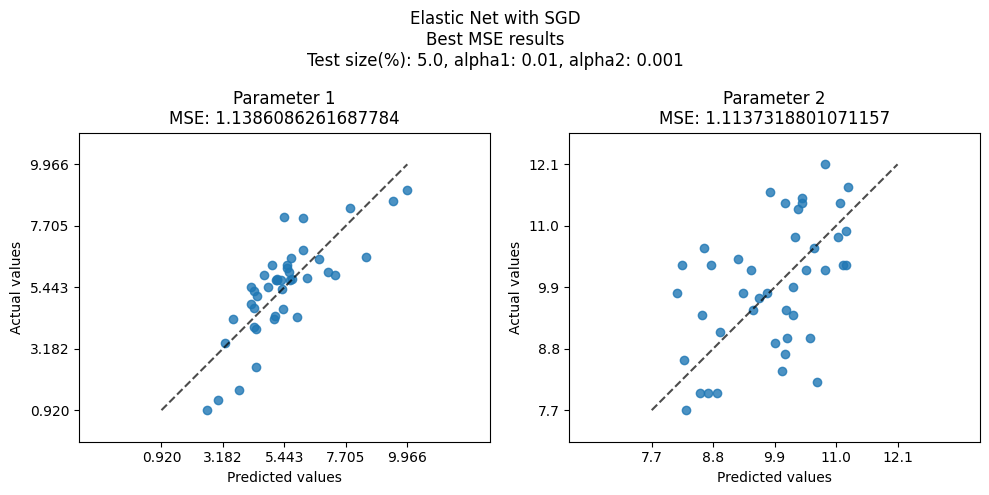

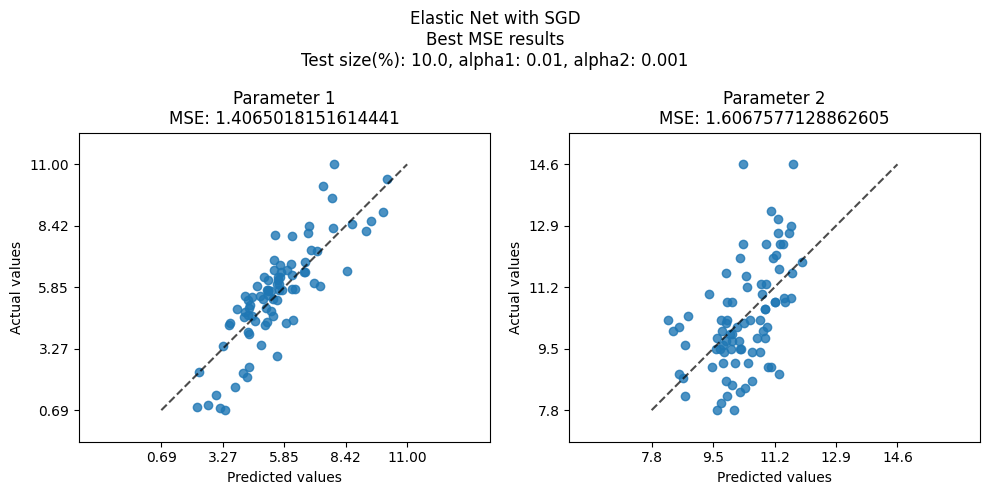

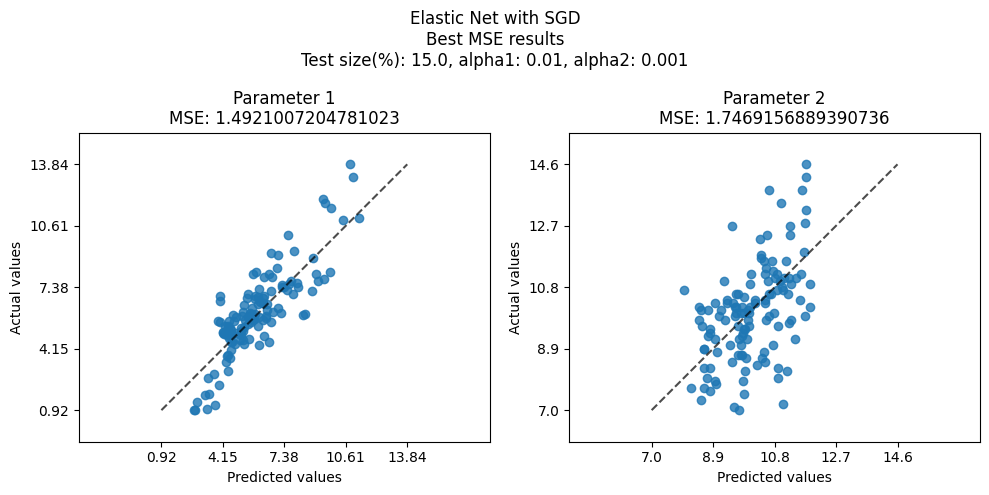

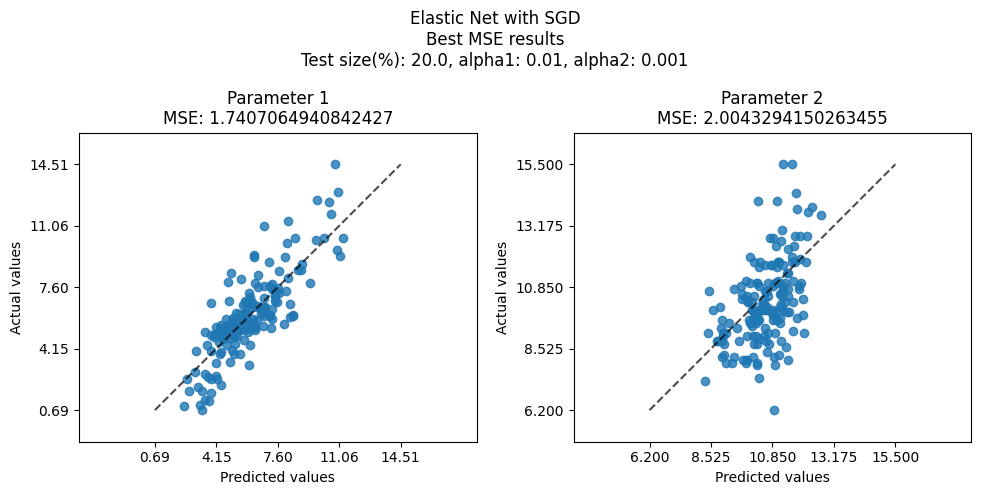

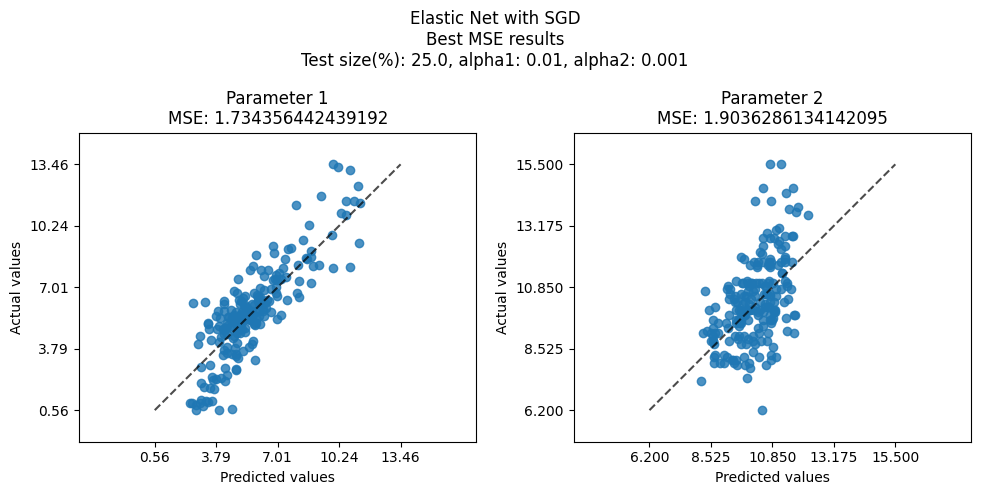

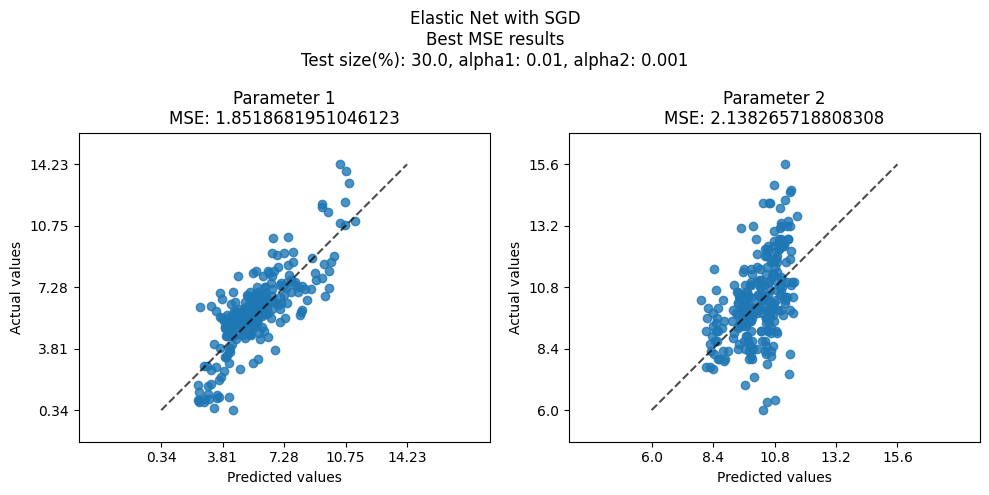

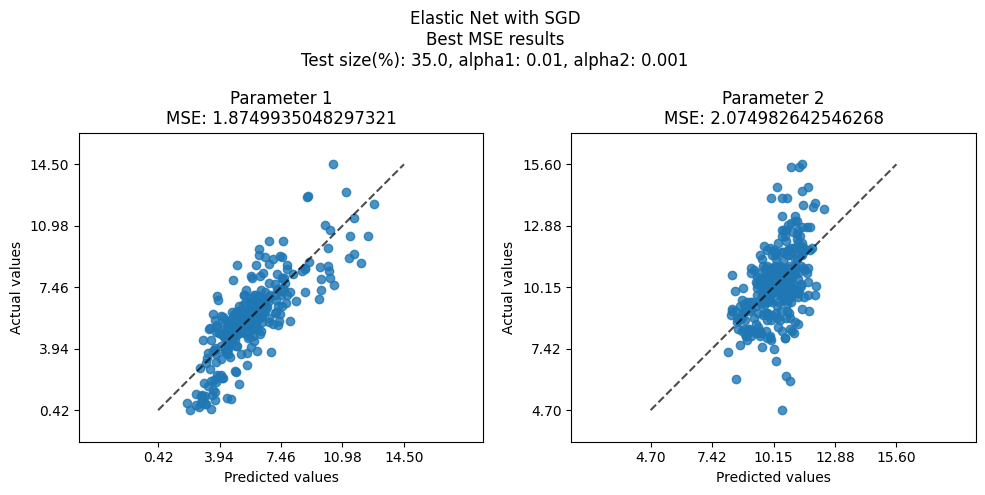

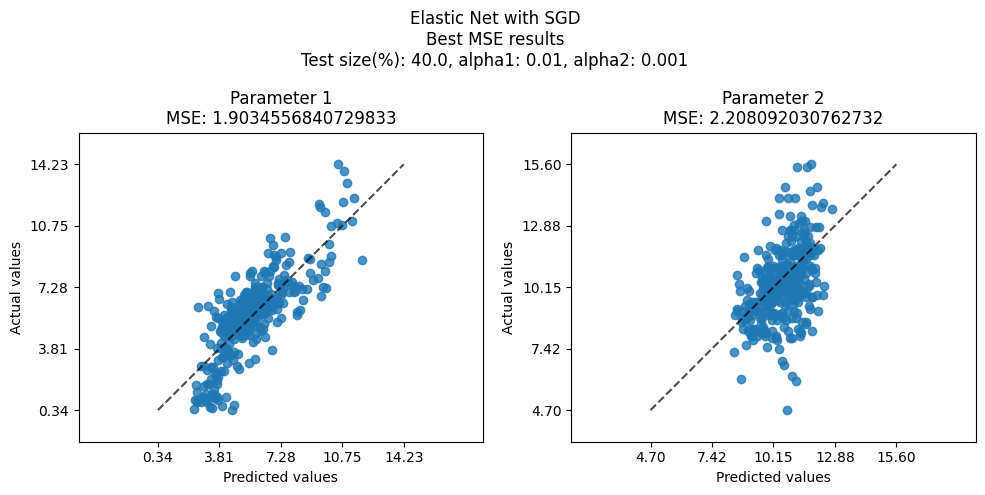

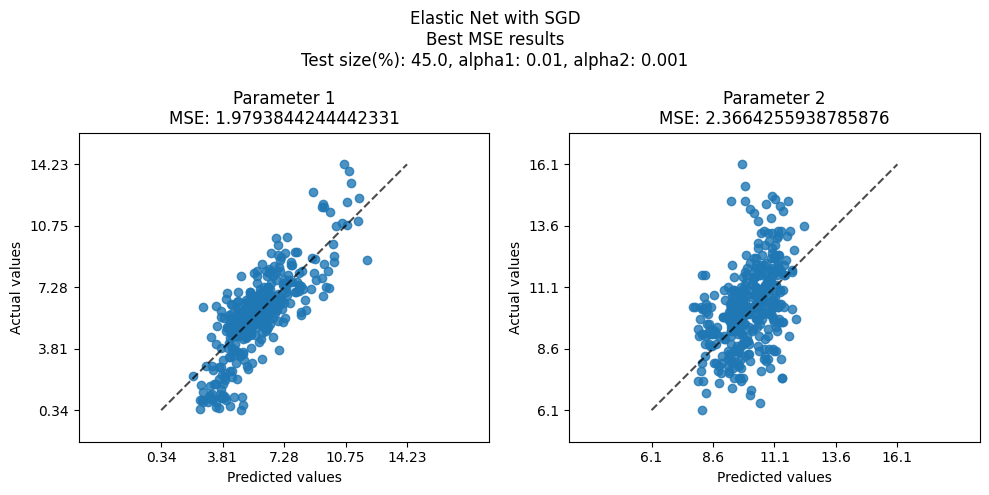

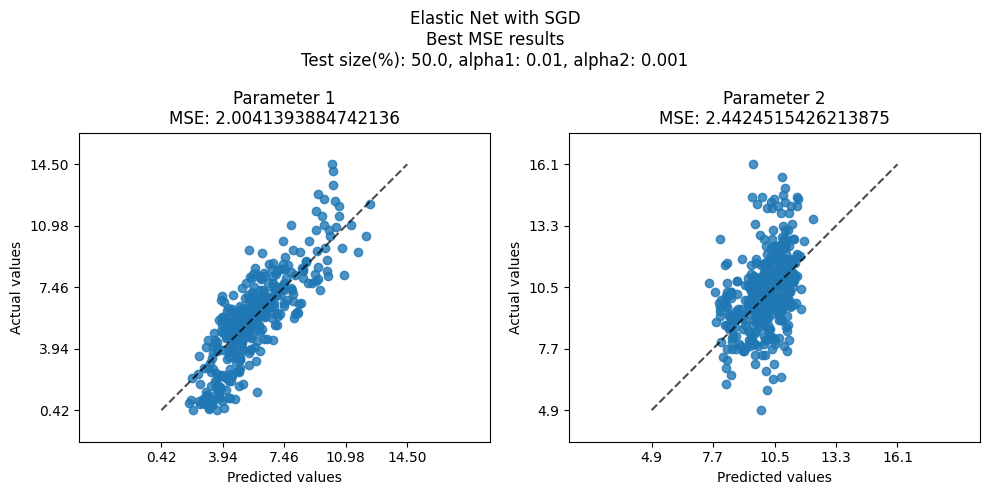

╔════════════════╦══════════════╦══════════════╦══════════════╦══════════════╦═════════════╦═════════════╗
║   Test size(%) ║   Best(MSE1) ║   Best(MSE2) ║   Mean(MSE1) ║   Mean(MSE2) ║   Var(MSE1) ║   Var(MSE2) ║
╠════════════════╬══════════════╬══════════════╬══════════════╬══════════════╬═════════════╬═════════════╣
║              5 ║      1.13861 ║      1.11373 ║      2.18688 ║      2.73611 ║   0.29686   ║   0.706098  ║
║             10 ║      1.4065  ║      1.60676 ║      2.18108 ║      2.69212 ║   0.147994  ║   0.268745  ║
║             15 ║      1.4921  ║      1.74692 ║      2.21854 ║      2.66693 ║   0.108911  ║   0.194442  ║
║             20 ║      1.74071 ║      2.00433 ║      2.25785 ║      2.68906 ║   0.0695932 ║   0.140492  ║
║             25 ║      1.73436 ║      1.90363 ║      2.29079 ║      2.73006 ║   0.0554425 ║   0.118439  ║
║             30 ║      1.85187 ║      2.13827 ║      2.31172 ║      2.78452 ║   0.0428072 ║   0.0957571 ║
║             35 ║      1.87499 ║    

In [16]:
from sklearn.linear_model import SGDRegressor

#number of trials
trials = 100
np.random.seed(42)
seeds = np.random.randint(trials, size=trials)

ripartisions = [i/100 for i in range(5,55,5)]
results = []  #["Ripartition", "Best_MSE1", "Best_MSE2","MSE1_mean","MSE2_mean","MSE1_var","MSE2_var"]


for ripartition in ripartisions:

    '''PARAM 1'''

    MSE_param1 = []

    best_MSE_1 = 100000000
    best_data_1 = {"Y_test":None, "Y_pred":None}

    i = 0
    for i in range(trials):
        #Ripartition in training and test and
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y[:,0], test_size=ripartition, random_state=seeds[i])
        elastic_reg_sgd = SGDRegressor(max_iter=5000, tol=1e-5, penalty="elasticnet", alpha=a1, l1_ratio = 0.5, eta0=0.01,
                                            n_iter_no_change=10, random_state=42)

        # Train the model using the training sets
        elastic_reg_sgd.fit(X_train, Y_train)

        # Make predictions using the testing set
        Y_pred_elastic_sgd =  elastic_reg_sgd.predict(X_test)

        #save MSE of the first parameters
        MSE_param1.append(mean_squared_error(Y_test,  Y_pred_elastic_sgd))

        #check if this is the best model in terms of MSE
        if MSE_param1[-1] < best_MSE_1:
          best_MSE_1 = MSE_param1[-1]
          best_data_1["Y_test"] = Y_test
          best_data_1["Y_pred"] =  Y_pred_elastic_sgd


    '''PARAM 2'''
    MSE_param2 = []

    best_MSE_2 = 100000000
    best_data_2 = {"Y_test":None, "Y_pred":None}

    i = 0
    for i in range(trials):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y[:,1], test_size=ripartition, random_state=seeds[i])
        elastic_reg_sgd = SGDRegressor(max_iter=5000, tol=1e-5, penalty="elasticnet", alpha=a2, l1_ratio = 0.5, eta0=0.01,
                                            n_iter_no_change=10, random_state=42)

        # Train the model using the training sets
        elastic_reg_sgd.fit(X_train, Y_train)

        # Make predictions using the testing set
        Y_pred_elastic_sgd = elastic_reg_sgd.predict(X_test)

        #save MSE of the second parameters
        MSE_param2.append(mean_squared_error(Y_test, Y_pred_elastic_sgd))

        #check if this is the best model in terms of MSE
        if MSE_param2[-1] < best_MSE_2:
          best_MSE_2 = MSE_param2[-1]
          best_data_2["Y_test"] = Y_test
          best_data_2["Y_pred"] = Y_pred_elastic_sgd

    results.append([str(ripartition *100 ), str(best_MSE_1), str(best_MSE_2),
     (np.mean(MSE_param1)),str(np.mean(MSE_param2)), str(np.var(MSE_param1)), str(np.var(MSE_param2))])

    '''PLOT THE BEST MODELS'''
    fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
    plt.subplots_adjust(wspace=0.3)
    PredictionErrorDisplay.from_predictions(y_true=best_data_1["Y_test"], y_pred=best_data_1["Y_pred"], kind = "actual_vs_predicted", ax=axs[0])
    axs[0].set_title("Parameter 1"+"\n"+ "MSE: " +  str(min(MSE_param1)))
    disp2= PredictionErrorDisplay.from_predictions(y_true=best_data_2["Y_test"], y_pred=best_data_2["Y_pred"], kind = "actual_vs_predicted", ax=axs[1])
    axs[1].set_title("Parameter 2"+"\n"+ "MSE: " +  str(min(MSE_param2)))
    fig.suptitle("Elastic Net with SGD"+"\n"+ "Best MSE results" + "\n"+ f"Test size(%): {ripartition * 100}"+", alpha1: "+str(a1) + ", alpha2: "+str(a2))
    plt.tight_layout()
    plt.show()


'''SHOW RESULTS'''
headers = ["Test size(%)","Best(MSE1)", "Best(MSE2)","Mean(MSE1)", "Mean(MSE2)", "Var(MSE1)", "Var(MSE2)"]

print(tabulate(results, headers,  tablefmt="double_outline"))

